##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 高斯过程隐变量模型

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/probability/examples/Gaussian_Process_Latent_Variable_Model"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/Gaussian_Process_Latent_Variable_Model.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/Gaussian_Process_Latent_Variable_Model.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a></td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/probability/examples/Gaussian_Process_Latent_Variable_Model.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>
</td>
</table>

隐变量模型会试图捕获高维数据中的隐藏结构。示例包括主分量分析 (PCA) 和因子分析。高斯过程是“非参数”模型，可以灵活地捕获局部相关结构和不确定度。高斯过程隐变量模型 ([Lawrence, 2004](https://papers.nips.cc/paper/2540-gaussian-process-latent-variable-models-for-visualisation-of-high-dimensional-data.pdf)) 结合了这些概念。

## 背景：高斯过程

高斯过程是随机变量的任何集合，因此在任何有限子集上的边缘分布都是多元正态分布。如需详细了解回归上下文中的 GP，请查看 [TensorFlow Probability 中的高斯过程回归](https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Regression_In_TFP.ipynb)。

我们使用所谓的*索引集*来标记 GP 所组成的集合中的每一个随机变量。在有限索引集的情况下，我们只会得到一个多元正态分布。然而，当我们考虑*有限*集合时，GP 最有趣。对于类似 $\mathbb{R}^D$ 的索引集（其中，我们对*$D$ 维空间中的每个点*都有一个随机变量），可以将 GP 视为随机*函数*上的分布。如果可以实现，从这样的 GP 中进行单次抽样，将为 $\mathbb{R}^D$ 中的每个点分配一个（联合正态分布的）值。在此 Colab 中，我们将关注一些 $\mathbb{R}^D$ 上的 GP。

正态分布完全由其一阶和二阶统计量确定，实际上，定义正态分布的一种方式是使其高阶累积量全部为零。GP 也是如此：我们可以通过描述均值和协方差<sup>*</sup>来完全指定 GP。回想一下，对于有限维多元正态分布，均值是一个向量，协方差是一个方形的对称正定矩阵。在无限维 GP 中，这些结构会泛化为均值*函数* $m : \mathbb{R}^D \to \mathbb{R}$（在索引集的每个点上定义），以及协方差“*内核*”函数，$k : \mathbb{R}^D \times \mathbb{R}^D \to \mathbb{R}$。内核函数必须为[正定](https://en.wikipedia.org/wiki/Positive-definite_function)，本质上是说，在有限点集合的限制下，它会产生一个正定矩阵。

GP 的大部分结构都衍生自其协方差内核函数，此函数描述了采样函数的值如何在邻近（或不那么邻近）点之间变化。不同的协方差函数会鼓励不同程度的平滑度。一种常用的内核函数是“指数二次函数”（又称“高斯函数”、“平方指数函数”或“径向基函数”），$k(x, x') = \sigma^2 e^{(x - x^2) / \lambda^2}$。其他示例在 David Duvenaud 的 [Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/) 页面和典籍 [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/) 中均有概述。

<sub>* 对于无限索引集，我们还需要一个一致性条件。由于 GP 的定义是有限边缘，因此我们必须要求这些边缘是一致的，而不考虑边缘采用的顺序。这在随机过程理论中是一个比较高级的话题，不在本教程的讨论范围内；只要事情最终得到解决即可！</sub>

## 应用 GP：回归和隐变量模型

使用 GP 的一种方式是回归：给定一组观测数据，其形式为输入 ${x_i}*{i=1}^N$（索引集的元素）和观测值 ${y_i}*{i=1}^N$，我们可以使用这些数据在新的点集 ${x_j^*}_{j=1}^M$ 处形成一个后验预测分布。由于分布都是高斯分布，因此可以归结为一些简单的线性代数（但请注意：必要的计算在数据点数量上具有运行时*立方*，并且在数据点数量上需要空间二次，这是使用 GP 的一个主要限制因素，目前的很多研究都集中在精确后验推断的计算上可行的替代方式上）。我们在 [TFP Colab 中的 GP 回归](https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Regression_In_TFP.ipynb)中更详细地介绍了 GP 回归。

使用 GP 的另一种方式是作为隐变量模型：给定高维观测值（例如，图像）的集合，我们可以设想某种低维隐结构。我们假设，在隐结构的条件下，大量的输出（图像中的像素）彼此独立。此模型中的训练包括：

1. 优化模型参数（例如，内核函数参数和观测噪声方差），以及
2. 在索引集中为每个训练观测值（图像）找到对应的点位置。所有优化都可以通过最大化数据的边缘对数似然来完成。

## 导入

In [ ]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 加载 MNIST 数据

In [ ]:
# Load the MNIST data set and isolate a subset of it.
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
N = 1000
small_x_train = x_train[:N, ...].astype(np.float64) / 256.
small_y_train = y_train[:N]

11501568/11490434 [==============================] - 0s 0us/step


## 准备可训练变量

我们将联合训练 3 个模型参数以及隐输入。

In [ ]:
# Create some trainable model parameters. We will constrain them to be strictly
# positive when constructing the kernel and the GP.
unconstrained_amplitude = tf.Variable(np.float64(1.), name='amplitude')
unconstrained_length_scale = tf.Variable(np.float64(1.), name='length_scale')
unconstrained_observation_noise = tf.Variable(np.float64(1.), name='observation_noise')

In [ ]:
# We need to flatten the images and, somewhat unintuitively, transpose from
# shape [100, 784] to [784, 100]. This is because the 784 pixels will be
# treated as *independent* conditioned on the latent inputs, meaning we really
# have a batch of 784 GP's with 100 index_points.
observations_ = small_x_train.reshape(N, -1).transpose()

# Create a collection of N 2-dimensional index points that will represent our
# latent embeddings of the data. (Lawrence, 2004) prescribes initializing these
# with PCA, but a random initialization actually gives not-too-bad results, so
# we use this for simplicity. For a fun exercise, try doing the
# PCA-initialization yourself!
init_ = np.random.normal(size=(N, 2))
latent_index_points = tf.Variable(init_, name='latent_index_points')

## 构造模型和训练运算

In [ ]:
# Create our kernel and GP distribution
EPS = np.finfo(np.float64).eps

def create_kernel():
  amplitude = tf.math.softplus(EPS + unconstrained_amplitude)
  length_scale = tf.math.softplus(EPS + unconstrained_length_scale)
  kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)
  return kernel

def loss_fn():
  observation_noise_variance = tf.math.softplus(
      EPS + unconstrained_observation_noise)
  gp = tfd.GaussianProcess(
      kernel=create_kernel(),
      index_points=latent_index_points,
      observation_noise_variance=observation_noise_variance)
  log_probs = gp.log_prob(observations_, name='log_prob')
  return -tf.reduce_mean(log_probs)

trainable_variables = [unconstrained_amplitude,
                       unconstrained_length_scale,
                       unconstrained_observation_noise,
                       latent_index_points]

optimizer = tf.optimizers.Adam(learning_rate=1.0)

@tf.function(autograph=False, jit_compile=True)
def train_model():
  with tf.GradientTape() as tape:
    loss_value = loss_fn()
  grads = tape.gradient(loss_value, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss_value

## 训练并绘制生成的隐嵌入向量

In [ ]:
# Initialize variables and train!
num_iters = 100
log_interval = 20
lips = np.zeros((num_iters, N, 2), np.float64)
for i in range(num_iters):
  loss = train_model()
  lips[i] = latent_index_points.numpy()
  if i % log_interval == 0 or i + 1 == num_iters:
    print("Loss at step %d: %f" % (i, loss))

Loss at step 0: 1108.121688
Loss at step 20: -159.633761
Loss at step 40: -263.014394
Loss at step 60: -283.713056
Loss at step 80: -288.709413
Loss at step 99: -289.662253


## 绘制结果

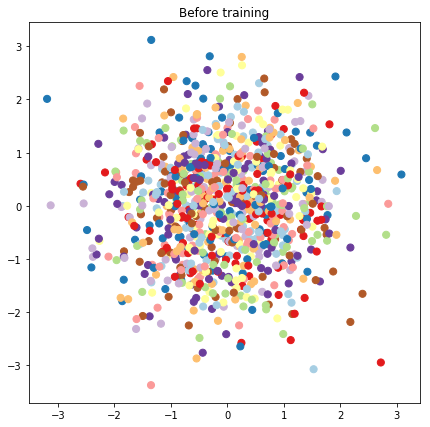

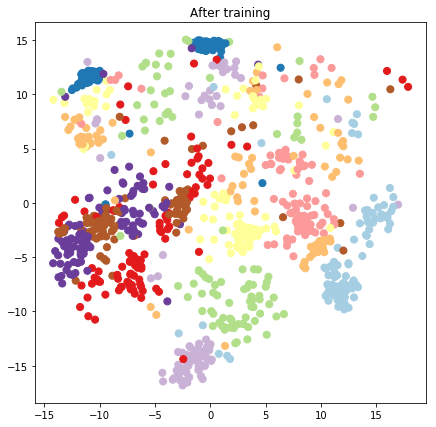

In [ ]:
# Plot the latent locations before and after training
plt.figure(figsize=(7, 7))
plt.title("Before training")
plt.grid(False)
plt.scatter(x=init_[:, 0], y=init_[:, 1],
           c=y_train[:N], cmap=plt.get_cmap('Paired'), s=50)
plt.show()

plt.figure(figsize=(7, 7))
plt.title("After training")
plt.grid(False)
plt.scatter(x=lips[-1, :, 0], y=lips[-1, :, 1],
           c=y_train[:N], cmap=plt.get_cmap('Paired'), s=50)
plt.show()

## 构造预测模型和采样运算

In [ ]:
# We'll draw samples at evenly spaced points on a 10x10 grid in the latent
# input space. 
sample_grid_points = 10
grid_ = np.linspace(-4, 4, sample_grid_points).astype(np.float64)
# Create a 10x10 grid of 2-vectors, for a total shape [10, 10, 2]
grid_ = np.stack(np.meshgrid(grid_, grid_), axis=-1)

# This part's a bit subtle! What we defined above was a batch of 784 (=28x28)
# independent GP distributions over the input space. Each one corresponds to a
# single pixel of an MNIST image. Now what we'd like to do is draw 100 (=10x10)
# *independent* samples, each one separately conditioned on all the observations
# as well as the learned latent input locations above.
#
# The GP regression model below will define a batch of 784 independent
# posteriors. We'd like to get 100 independent samples each at a different
# latent index point. We could loop over the points in the grid, but that might
# be a bit slow. Instead, we can vectorize the computation by tacking on *even
# more* batch dimensions to our GaussianProcessRegressionModel distribution.
# In the below grid_ shape, we have concatentaed
#   1. batch shape: [sample_grid_points, sample_grid_points, 1]
#   2. number of examples: [1]
#   3. number of latent input dimensions: [2]
# The `1` in the batch shape will broadcast with 784. The final result will be
# samples of shape [10, 10, 784, 1]. The `1` comes from the "number of examples"
# and we can just `np.squeeze` it off.
grid_ = grid_.reshape(sample_grid_points, sample_grid_points, 1, 1, 2)

# Create the GPRegressionModel instance which represents the posterior
# predictive at the grid of new points.
gprm = tfd.GaussianProcessRegressionModel(
    kernel=create_kernel(),
    # Shape [10, 10, 1, 1, 2]
    index_points=grid_,
    # Shape [1000, 2]. 1000 2 dimensional vectors.
    observation_index_points=latent_index_points,
    # Shape [784, 1000]. A batch of 784 1000-dimensional observations.
    observations=observations_)

## 以数据和隐嵌入向量为条件抽取样本

我们在隐空间的二维网格上对 100 个点进行采样。

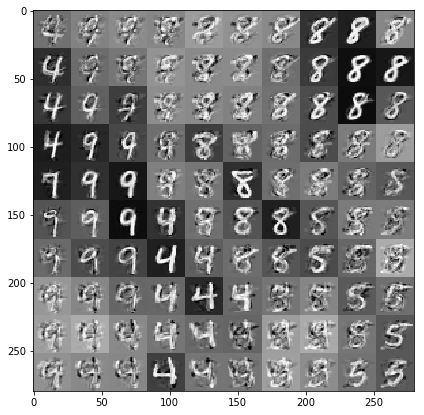

In [ ]:
samples = gprm.sample()

# Plot the grid of samples at new points. We do a bit of tweaking of the samples
# first, squeezing off extra 1-shapes and normalizing the values.
samples_ = np.squeeze(samples.numpy())
samples_ = ((samples_ -
             samples_.min(-1, keepdims=True)) /
            (samples_.max(-1, keepdims=True) -
             samples_.min(-1, keepdims=True)))
samples_ = samples_.reshape(sample_grid_points, sample_grid_points, 28, 28)
samples_ = samples_.transpose([0, 2, 1, 3])
samples_ = samples_.reshape(28 * sample_grid_points, 28 * sample_grid_points)
plt.figure(figsize=(7, 7))
ax = plt.subplot()
ax.grid(False)
ax.imshow(-samples_, interpolation='none', cmap='Greys')
plt.show()

## 结论

我们简要介绍了高斯过程潜变量模型，并展示了如何仅用几行 TF 和 TF Probability 代码实现它。